# Homework 8

In this homework, you will be training a sequence-to-sequence model. Unfortunately, these models can be somewhat expensive to train, and the free GPU/TPU from colab is not sufficient to train a sequence-to-sequence model on a terribly large/difficult task. So, you will be translating short phrases from English to French using a small dataset comes from [Tatoeba](tatoeba.org).

This homework contains example pytorch code that mainly comes from the textbook. There is an analogous mxnet example in the textbook you can use instead.

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-en.git matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-en.git to /tmp/pip-req-build-b2cuc9cm
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-en.git /tmp/pip-req-build-b2cuc9cm
  Resolved https://github.com/d2l-ai/d2l-en.git to commit f37303e611200cb12e5e04ac5f784e0e37ae3c97
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.3 MB/s eta 0:00:00
  Created wheel for d2l: filename=d2l-1.0

In [2]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# Example sequence-to-sequence model implementation

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['sois', 'calme', '.'], bleu,0.492
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


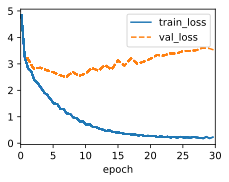

In [3]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens) Last hidden state
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                    save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

# Problems

1. In the example, sequence-to-sequence learning is enabled by initializing the decoder state with the final encoder state and by concatenating the final encoder state with the embeddings used as input to the decoder. Modify the code so that the final encoder state is *only* used to initialize the decoder, *not* concatenated with the decoder embeddings. Does this change the loss and/or the predictions of the model? Why do you think this is?
1. The prediction function above uses greedy sampling (choosing the most probable token at each time step). Change it so that it instead samples randomly at each time step according to the predicted distribution. Generate the predictions a few times for the example English sentences provided. Do they ever change? Why do you think they do or don't change? Hint: You will need to implement a categorical sampler. One way to do this is with [torch.multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html).
1. In class, we discussed deep RNNs, which consist of stacks of RNN layers. The example code has two GRU layers in the encoder and two GRU layers in the decoder. Change it to only have a single layer in the encoder and a single layer in the decoder. Is training faster or slower? Is the final loss higher or lower?

### Problem 1

In [4]:
class Seq2SeqDecoder2(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens,
                           num_layers)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        enc_output, hidden_state = enc_all_outputs 
        return hidden_state

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        hidden_state = state
        outputs, hidden_state = self.rnn(embs, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, hidden_state

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


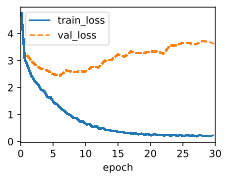

In [5]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder2(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

In the modified formulation, although the loss curves look nearly identical for both the training and validation losses, the third prediction differs between the two models. When concatenating the context to the decoder hidden states, the decoder has information injected into it from the entire sequence at each timestep. Although intuition would posit that this approach may be brittle w.r.t the choice of context (for example, RNN last hidden states disproportionately overrepresent later tokens in their hidden states), we in fact see an increase in blue score for the third example when empirically testing both approaches. The significance of one example might not be too high but it can be explained by the fact that injecting information about the original sequence at each decoding timestep offers more information than just including it in the beginning to initialize the decoding.

### Problem 2

In [73]:
class Seq2SeqMultinomial(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2SeqMultinomial, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                    save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
        for i in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            # Multinomial Distribution over the Output
            prob_mass = torch.exp(Y).squeeze(1)                  # Make positive
            sampled_char = torch.multinomial(prob_mass, 1)
            outputs.append(sampled_char)
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights


go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ["c'est", 'plus', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


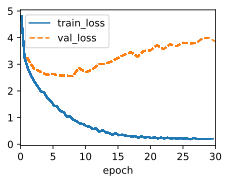

In [74]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2SeqMultinomial(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

After switching the greedy sampler (argmax) to a categorical sampler (multinomial sampling) and running the prediction multiple times, we can see that the predicted outputs actually do vary over time, however only for the third example (he's calm). It is likely that this example has a flatter distribution over the tokens compared to the others and as such a probabilistic sampler would be able to sample more tokens than a deterministic which just goes with the highest probability one.

### Problem 3

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['soyez', 'calmes', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


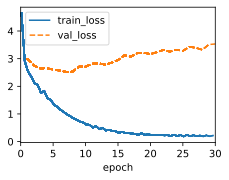

In [75]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 1, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

Switching from a deeper RNN to a more shallow RNN didn't have a huge impact on the training time of the rnn. This may be due to GPU usage and the parallelization of computation and without testing on CPU, it would be hard to tell. Furthermore the difference between final losses is neglibile as well.